# MNIST: The “Hello world” of machine learning

##### Copyright 2020

Licensed under the MIT License.

In [1]:
# Copyright 2020 Guido Carlo Ferrante
#
# Licensed under the MIT License. 
# 
# Permission is hereby granted, free of charge, to any person obtaining a copy
# of this software and associated documentation files (the "Software"), to deal
# in the Software without restriction, including without limitation the rights
# to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
# copies of the Software, and to permit persons to whom the Software is
# furnished to do so, subject to the following conditions:
# 
# The above copyright notice and this permission notice shall be included in all
# copies or substantial portions of the Software.
# 
# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
# AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
# OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
# SOFTWARE.
# ==============================================================================

## Overview

One of the earliest successes of machine learning was digit recognition (LeCun, 1989). One application was automatic digit recognition on cheques.

We use the MNIST database, which is already available in Keras.

In [2]:
# Import tensorflow
%tensorflow_version 2.x
import tensorflow as tf
# Import MNIST
mnist = tf.keras.datasets.mnist
# mnist = tf.keras.datasets.fashion_mnist
# Check that tf sees the GPU
device_name = tf.test.gpu_device_name()
print(device_name)


/device:GPU:0


In [3]:
# Import other libraries
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.style.use('seaborn-pastel')

In [4]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'  # this makes plot in high res

## Vanilla model

The vanilla version of the architecture is just a neural network that is trained on part of the data and validated on the remaining part. First of all, we load the data and normalize (neural networks work best with normalized data).

In [5]:
# training pairs, validation pairs: each pair is (data, label)
(x_t, y_t), (x_v, y_v) = mnist.load_data()
n_t_samples = x_t.shape[0] # number of training samples

# normalize the data
x_t = x_t.astype(np.float32)
x_v = x_v.astype(np.float32)

x_t = x_t/255.0
x_v = x_v/255.0

n_epochs = 3

11493376/11490434 [==============================] - 1s 0us/step


In [6]:
print(x_t.shape)
print(y_t.shape)

(60000, 28, 28)
(60000,)


We can take a look at one sample.

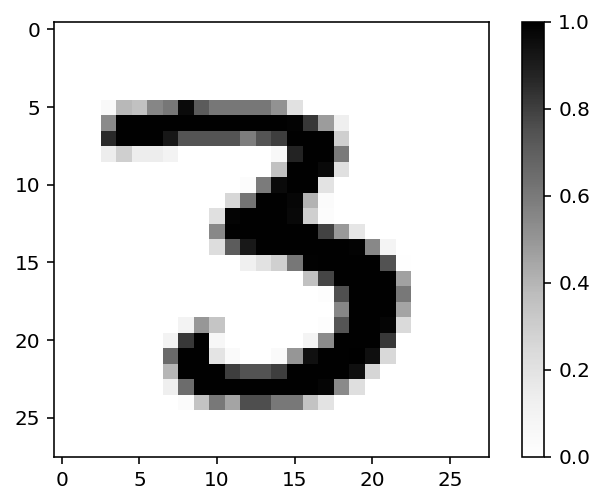

In [7]:
plt.imshow(x_t[12], cmap=plt.get_cmap('Greys'))
plt.colorbar();

The neural network is defined by the model below, which is characterized by having:

* one hidden layer only
* the output layer is made of 10 neurons, one per class, and it outputs the distribution over the classes.



In [8]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(16, activation=tf.nn.relu)) # first hidden
model.add(tf.keras.layers.Dense(10, activation=tf.nn.softmax)) # output layer
model.compile(optimizer='adam', 
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])

At this point, we can fit the model over the data. To speed up the process, we use only half of the available training data. In a real project, we won't do this of course.

In [9]:
n_samples_used = int(0.25 * x_t.shape[0])

model.fit(x_t[0:n_samples_used], y_t[0:n_samples_used], epochs=n_epochs)

Epoch 1/3
469/469 [==============================] - 1s 2ms/step - loss: 0.7581 - accuracy: 0.8029
Epoch 2/3
469/469 [==============================] - 1s 2ms/step - loss: 0.3523 - accuracy: 0.9017
Epoch 3/3
469/469 [==============================] - 1s 2ms/step - loss: 0.2975 - accuracy: 0.9166


After fitting the model, let's check how it performs on out-of-sample data.

In [10]:
val_loss, val_acc = model.evaluate(x_v, y_v)

313/313 [==============================] - 1s 2ms/step - loss: 0.2910 - accuracy: 0.9164


Pretty well! Over 92% of accuracy. However, accuracy is not everything! Let's check the confusion matrix.

In [11]:
y_pred = model.predict(x_v)
y_pred_labels = np.argmax(y_pred, axis=1)
cm = tf.math.confusion_matrix(labels=y_v, predictions=y_pred_labels, num_classes=10)

Let's see how the confusion matrix looks like. The more diagonal, the better.

tf.Tensor(
[[ 958    0    1    2    0    6    8    1    4    0]
 [   0 1115    1    3    2    1    4    1    8    0]
 [  10    6  903   22   14    1   12   12   49    3]
 [   2    0   15  925    1   28    2   10   22    5]
 [   1    2    7    0  929    0   13    2    8   20]
 [   9    3    7   45    9  752   15    5   41    6]
 [  12    3    9    2   11   12  905    1    3    0]
 [   3   20   23   10    9    0    0  918    1   44]
 [   5    8    8   24   11   25    8    7  860   18]
 [  12    7    1   11   57    7    0   11    9  894]], shape=(10, 10), dtype=int32)


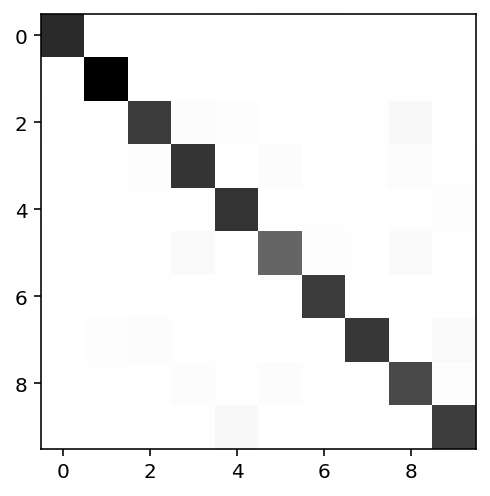

In [12]:
C = cm
print(C)
plt.imshow(C, interpolation='nearest', cmap='Greys')

It looks pretty diagonal. However, these are absolute numbers! We don't know if one class happens to be more present than others in the validation set. We can check this as follows.

In [13]:
print(np.sum(C, axis=1))

[ 980 1135 1032 1010  982  892  958 1028  974 1009]


It makes then a lot of sense to divide the numbers in each row by their sum because each row corresponds to a class and different columns correspond to the misclassified class. For example, there is a 9 in the first row, sixth column, which means that 9 times a 0 (first row) was predicted to be a 5 (sixth column). 

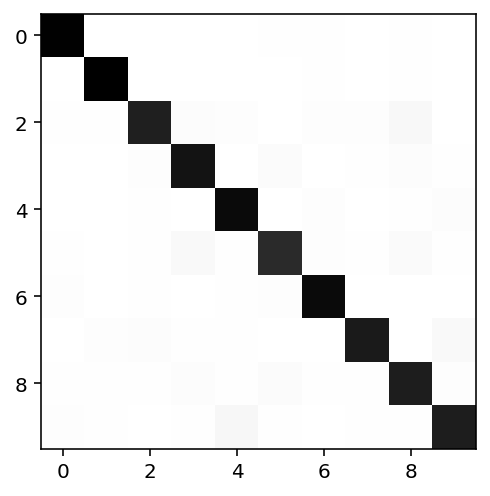

In [14]:
C_norm = C / np.sum(C, axis=1)
plt.imshow(C_norm, interpolation='nearest', cmap='Greys')

The normalization step is quite important because dealing with the former confusion matrix can be misleading. For example, in the former matrix we can see that some entries are much lighter than others, e.g. the number 5, but this is only because 5 is the least present class in the validation set.

At this point, we might be interested in understanding what goes wrong when it goes wrong.

[[0.    0.    0.001 0.002 0.    0.007 0.008 0.001 0.004 0.   ]
 [0.    0.    0.001 0.003 0.002 0.001 0.004 0.001 0.008 0.   ]
 [0.01  0.005 0.    0.022 0.014 0.001 0.013 0.012 0.05  0.003]
 [0.002 0.    0.015 0.    0.001 0.031 0.002 0.01  0.023 0.005]
 [0.001 0.002 0.007 0.    0.    0.    0.014 0.002 0.008 0.02 ]
 [0.009 0.003 0.007 0.045 0.009 0.    0.016 0.005 0.042 0.006]
 [0.012 0.003 0.009 0.002 0.011 0.013 0.    0.001 0.003 0.   ]
 [0.003 0.018 0.022 0.01  0.009 0.    0.    0.    0.001 0.044]
 [0.005 0.007 0.008 0.024 0.011 0.028 0.008 0.007 0.    0.018]
 [0.012 0.006 0.001 0.011 0.058 0.008 0.    0.011 0.009 0.   ]]


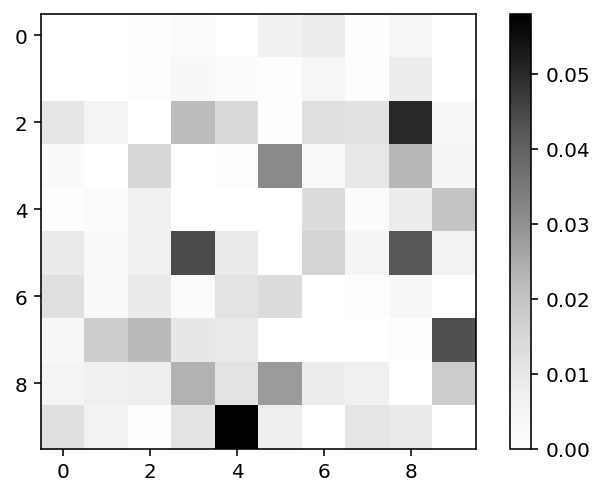

In [15]:
diag_C_norm = np.diagonal(C_norm)
C_norm_0 = C_norm - np.diag(diag_C_norm)
print(np.around(C_norm_0, 3))
plt.imshow(C_norm_0, interpolation='nearest', cmap='Greys')
plt.colorbar();

We can actually see that most times (5.7%) it is 4 that is misclassified as 6, followed by 9 misclassified as 5 (4.2%).

If we repeat all these steps with the whole dataset and a few more epochs, we might improve a little bit. Let's check.

Epoch 1/3
1875/1875 [==============================] - 4s 2ms/step - loss: 0.2784 - accuracy: 0.9215
Epoch 2/3
1875/1875 [==============================] - 4s 2ms/step - loss: 0.2421 - accuracy: 0.9314
Epoch 3/3
313/313 [==============================] - 1s 2ms/step - loss: 0.2129 - accuracy: 0.9403
[0.21290136873722076, 0.9402999877929688]
[[0.    0.    0.    0.002 0.    0.003 0.006 0.003 0.003 0.   ]
 [0.    0.    0.004 0.002 0.001 0.001 0.004 0.001 0.014 0.001]
 [0.005 0.001 0.    0.017 0.006 0.002 0.007 0.009 0.02  0.004]
 [0.    0.    0.015 0.    0.    0.013 0.    0.006 0.012 0.009]
 [0.    0.001 0.005 0.001 0.    0.    0.011 0.004 0.009 0.028]
 [0.006 0.001 0.001 0.042 0.002 0.    0.009 0.007 0.025 0.006]
 [0.01  0.003 0.003 0.001 0.007 0.013 0.    0.001 0.006 0.   ]
 [0.001 0.007 0.019 0.009 0.005 0.002 0.    0.    0.003 0.028]
 [0.008 0.002 0.005 0.03  0.01  0.016 0.008 0.006 0.    0.011]
 [0.004 0.005 0.002 0.013 0.011 0.002 0.002 0.01  0.008 0.   ]]


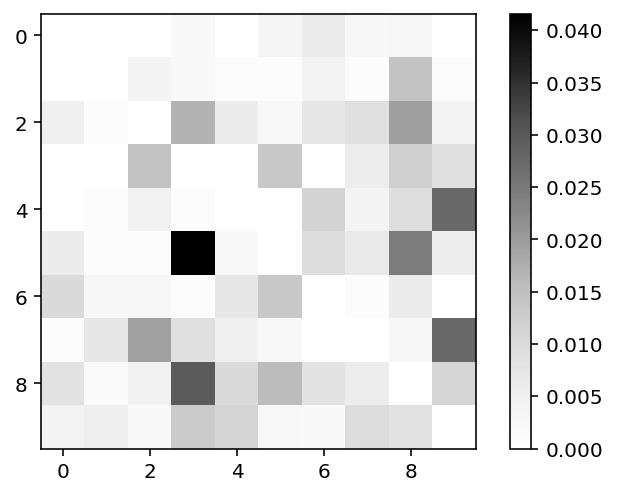

In [16]:
# set epochs and use the whole dataset to fit
n_epochs = 3
n_samples_used = int(1 * x_t.shape[0])

model.fit(x_t[0:n_samples_used], y_t[0:n_samples_used], epochs=n_epochs)

# evaluate accuracy
val_loss, val_acc = model.evaluate(x_v, y_v)
print([val_loss, val_acc])

# evaluate confusion matrix
y_pred = model.predict(x_v)
y_pred_labels = np.argmax(y_pred, axis=1)
cm = tf.math.confusion_matrix(labels=y_v, predictions=y_pred_labels, num_classes=10)

C = cm

C_norm = C / np.sum(C, axis=1)
diag_C_norm = np.diagonal(C_norm)
C_norm_0 = C_norm - np.diag(diag_C_norm)
print(np.around(C_norm_0, 3))
plt.imshow(C_norm_0, interpolation='nearest', cmap='Greys')
plt.colorbar();


It is indeed better, with 94% accuracy and a confusion matrix whose maximum value is about 2.5%. How to get better results from here? Let's try to augment the data.

## Data augmentation

Augmenting the dataset means creating data from data in some way. The idea behind data augmentation is that we help the network to not overfit the dataset. A clear way to do this with images is, for example, rotating each digit and fitting the network to the augmented dataset.

In [17]:
# from scipy import ndimage

# def rot(X, theta):
#     return ndimage.rotate(X, theta, reshape=False) # theta in degrees
  
# n_samples_used = int(1 * x_t.shape[0])

# angles = np.array([-10, 0, 10])
# n_aug = len(angles)

# x_t_aug = np.zeros(shape=(n_samples_used * n_aug, x_t.shape[1], x_t.shape[2]))
# y_t_aug = np.repeat(y_t[0:n_samples_used], n_aug)

# for sample in range(n_samples_used):
#     for aug in range(n_aug):
#         x_t_aug[sample * n_aug + aug] = rot(x_t[sample], angles[aug])
        
# model.fit(x_t_aug, y_t_aug, epochs=n_epochs)

# # evaluate accuracy
# val_loss, val_acc = model.evaluate(x_v, y_v)

A little improvement, indeed.

The previous code was quite slow. The code spent most of the time in the `rot` function, which does not use the GPU. If we use the GPU, we can save a lot of time. Let's see how. This time we will augment the data in a slightly different way, just to see the effect of another augmentation.

In [50]:
# !pip install -q --no-deps tensorflow-addons~=0.7
!pip install tensorflow-addons
!pip install tfa-nightly
import tensorflow_addons as tfa

     |████████████████████████████████| 1.1MB 3.4MB/s 


In [54]:
# Prepare data
data = x_t
images = tf.reshape(data, (x_t.shape[0], x_t.shape[1], x_t.shape[2], 1))

# Augment n_aug times
n_aug = 2
rotated = None
for aug in range(n_aug-1):
  tf.random.set_seed(aug)  # for reproducibility
  # Generate random angles
  random_angles = tf.random.uniform(shape = (tf.shape(x_t)[0], ), minval = -np.pi/8, maxval =  np.pi/8)
  # Rotate this batch
  rotated_batch = tfa.image.rotate(images, random_angles)
  
  if rotated is None:
    rotated = rotated_batch
  else:
    rotated = np.append(rotated, rotated_batch, axis=0)

# reshape
rotated = tf.reshape(rotated, (-1, x_t.shape[1], x_t.shape[2]))

# augment
x_t_aug = np.append(x_t, rotated, axis=0)
y_t_aug = np.array(list(y_t) * n_aug)

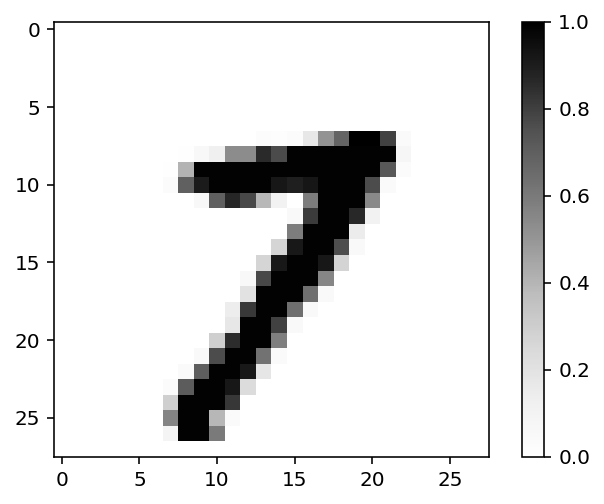

In [55]:
plt.imshow(x_t[40000], cmap=plt.get_cmap('Greys'))
plt.colorbar();

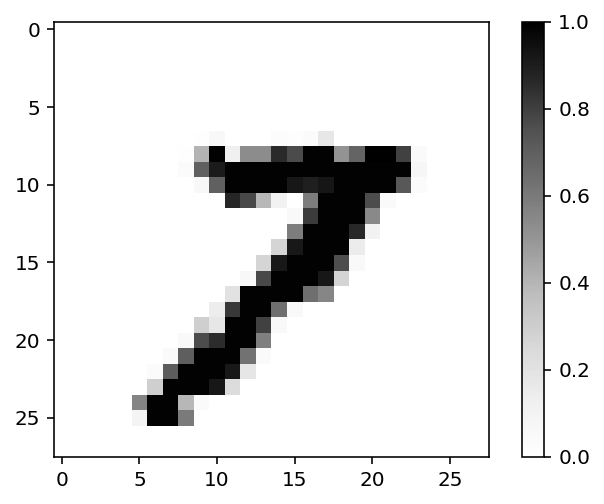

In [56]:
plt.imshow(x_t_aug[100000], cmap=plt.get_cmap('Greys'))
plt.colorbar();

Now we can evaluate the model on the augmented pictures.

In [57]:
model.fit(x_t_aug, y_t_aug, epochs=n_epochs)

print('Validate')
val_loss, val_acc = model.evaluate(x_v, y_v)

Epoch 1/3
3750/3750 [==============================] - 8s 2ms/step - loss: 0.2703 - accuracy: 0.9216
Epoch 2/3
3750/3750 [==============================] - 8s 2ms/step - loss: 0.2317 - accuracy: 0.9320
Epoch 3/3
3750/3750 [==============================] - 8s 2ms/step - loss: 0.2124 - accuracy: 0.9370
Validate
313/313 [==============================] - 1s 2ms/step - loss: 0.1816 - accuracy: 0.9490


Same performance as before. We can see that accuracy during fitting is slightly lower than before, but in the validation set we get the same performance, ergo the network is generalizing well.

## A deeper network

Going deeper just means adding layers.

In [11]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Flatten())  # Input layer
model.add(tf.keras.layers.Dense(32, activation=tf.nn.relu)) # first hidden
model.add(tf.keras.layers.Dense(16, activation=tf.nn.relu)) # second hidden
model.add(tf.keras.layers.Dense(10, activation=tf.nn.softmax)) # output layer
model.compile(optimizer='adam', 
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])

In [12]:
model.fit(x_t, y_t, epochs=n_epochs)
print('Validate')
val_loss, val_acc = model.evaluate(x_v, y_v)

Epoch 1/3
1875/1875 [==============================] - 3s 2ms/step - loss: 0.3635 - accuracy: 0.8942
Epoch 2/3
1875/1875 [==============================] - 3s 2ms/step - loss: 0.1813 - accuracy: 0.9463
Epoch 3/3
1875/1875 [==============================] - 3s 2ms/step - loss: 0.1430 - accuracy: 0.9571
Validate
313/313 [==============================] - 1s 2ms/step - loss: 0.1354 - accuracy: 0.9597


We can also go large and deep. The larger and the deeper we go, the more likely we overfit the dataset. But for the moment, let's not implement any technique to reduce the possible overfitting, and just try it. In the next section, we'll see one of the many methods to address overfitting.

In [13]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Flatten())  # Input layer
model.add(tf.keras.layers.Dense(256, activation=tf.nn.relu)) # first hidden
model.add(tf.keras.layers.Dense(64, activation=tf.nn.relu)) # second hidden
model.add(tf.keras.layers.Dense(16, activation=tf.nn.relu)) # third hidden
model.add(tf.keras.layers.Dense(10, activation=tf.nn.softmax)) # output layer
model.compile(optimizer='adam', 
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])

In [14]:
model.fit(x_t, y_t, epochs=n_epochs)
print('Validate')
val_loss, val_acc = model.evaluate(x_v, y_v)

Epoch 1/3
1875/1875 [==============================] - 4s 2ms/step - loss: 0.2458 - accuracy: 0.9269
Epoch 2/3
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0956 - accuracy: 0.9711
Epoch 3/3
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0665 - accuracy: 0.9796
Validate
313/313 [==============================] - 1s 2ms/step - loss: 0.0769 - accuracy: 0.9752


We see that we are overfit. Indeed, the accuracy in the validation set is lower than the accuracy in the training set. We would get the same result by, for example, training _less_. If we keep going with the training, the end result will not improve.

In [15]:
model.fit(x_t_aug, y_t_aug, epochs=n_epochs-1)
print('Validate')
val_loss, val_acc = model.evaluate(x_v, y_v)

NameError: ignored

Finally, it is quite known that `elu` is sometimes better than `relu` for several reasons. Let's try it.

In [ ]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Flatten())  # Input layer
model.add(tf.keras.layers.Dense(256, activation=tf.nn.elu)) # first hidden
model.add(tf.keras.layers.Dense(64, activation=tf.nn.elu)) # second hidden
model.add(tf.keras.layers.Dense(16, activation=tf.nn.elu)) # third hidden
model.add(tf.keras.layers.Dense(10, activation=tf.nn.softmax)) # output layer
model.compile(optimizer='adam', 
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])

In [ ]:
model.fit(x_t, y_t, epochs=n_epochs)
print('Validate')
val_loss, val_acc = model.evaluate(x_v, y_v)

Same result. Since we see that the network is just too big, we should reduce it somehow.

In [ ]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Flatten())  # Input layer
model.add(tf.keras.layers.Dense(128, activation=tf.nn.relu)) # first hidden
model.add(tf.keras.layers.Dense(32, activation=tf.nn.relu)) # second hidden
model.add(tf.keras.layers.Dense(16, activation=tf.nn.relu)) # third hidden
model.add(tf.keras.layers.Dense(10, activation=tf.nn.softmax)) # output layer
model.compile(optimizer='adam', 
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])

In [ ]:
model.fit(x_t, y_t, epochs=n_epochs)
print('Validate')
val_loss, val_acc = model.evaluate(x_v, y_v)

The morale is that we improved by 1% in the validation set by simply making the network larger and deeper, but at the cost of i) being prone to overfitting, and ii) being slower.

## Very deep networks

We cannot just add many layers if we want to use very deep networks. The problem is that of vanishing or exploding gradients. For example, 100 layers is already a number of layers that is not trainable with standard methods.


In [67]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Flatten())  # Input layer
model.add(tf.keras.layers.Dense(128, activation=tf.nn.elu)) # first hidden

for l in range(98):
  model.add(tf.keras.layers.Dense(64, activation=tf.nn.elu)) # middle layers

model.add(tf.keras.layers.Dense(10, activation=tf.nn.softmax)) # output layer
model.compile(optimizer='adam', #tf.keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999), #
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])

In [68]:
model.fit(x_t, y_t, epochs=n_epochs)
print('Validate')
val_loss, val_acc = model.evaluate(x_v, y_v)

Epoch 1/3
1875/1875 [==============================] - 17s 9ms/step - loss: 2.3055 - accuracy: 0.1081
Epoch 2/3
1875/1875 [==============================] - 17s 9ms/step - loss: 2.3023 - accuracy: 0.1109
Epoch 3/3
1875/1875 [==============================] - 17s 9ms/step - loss: 2.3021 - accuracy: 0.1115
Validate
313/313 [==============================] - 1s 4ms/step - loss: 2.3023 - accuracy: 0.1135


The major problem here is to use the Adam optimizer. Using SGD instead yields the following results.

In [69]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Flatten())  # Input layer
model.add(tf.keras.layers.Dense(128, activation=tf.nn.elu)) # first hidden

for l in range(98):
  model.add(tf.keras.layers.Dense(64, activation=tf.nn.elu)) # middle layers

model.add(tf.keras.layers.Dense(10, activation=tf.nn.softmax)) # output layer
model.compile(optimizer=tf.keras.optimizers.SGD(lr=1e-3), # not 'adam'
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])

In [70]:
model.fit(x_t, y_t, epochs=n_epochs)
print('Validate')
val_loss, val_acc = model.evaluate(x_v, y_v)

Epoch 1/3
1875/1875 [==============================] - 15s 8ms/step - loss: 2.0656 - accuracy: 0.2000
Epoch 2/3
1875/1875 [==============================] - 15s 8ms/step - loss: 1.6547 - accuracy: 0.3249
Epoch 3/3
1875/1875 [==============================] - 15s 8ms/step - loss: 1.3269 - accuracy: 0.4734
Validate
313/313 [==============================] - 1s 4ms/step - loss: 1.2150 - accuracy: 0.5393


We can easily build very deep networks by using the `selu` activation, which avoids the gradient vanishing and explosion problems. 

In [71]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Flatten())  # Input layer
model.add(tf.keras.layers.Dense(128, activation='selu', kernel_initializer='lecun_normal')) # first hidden #tf.keras.initializers.lecun_normal(seed=None)
# model.add(tf.keras.layers.Dense(128, activation=tf.nn.selu)) # first hidden #tf.keras.initializers.lecun_normal(seed=None)

for l in range(98):
  # model.add(tf.keras.layers.Dense(16, activation=tf.nn.selu)) # middle layers
  model.add(tf.keras.layers.Dense(64, activation='selu', kernel_initializer='lecun_normal')) # middle layers

model.add(tf.keras.layers.Dense(10, activation=tf.nn.softmax)) # output layer
model.compile(optimizer=tf.keras.optimizers.SGD(lr=1e-3), # not 'adam'
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])

In [72]:
model.fit(x_t, y_t, epochs=n_epochs)
print('Validate')
val_loss, val_acc = model.evaluate(x_v, y_v)

Epoch 1/3
1875/1875 [==============================] - 15s 8ms/step - loss: 1.8011 - accuracy: 0.3303
Epoch 2/3
1875/1875 [==============================] - 15s 8ms/step - loss: 0.9773 - accuracy: 0.6708
Epoch 3/3
1875/1875 [==============================] - 15s 8ms/step - loss: 0.9259 - accuracy: 0.6983
Validate
313/313 [==============================] - 1s 4ms/step - loss: 0.8140 - accuracy: 0.7549


The take away is that SGD is better than Adam with the ELU and SELU activation.

Apparently, we should normalize the input data to get zero mean and unit variance in order to use SELU. Let's do that, and investigate later whether this is needed in our present case.

In [73]:
def normalize(x):
  X = np.reshape(x, [-1, x.shape[1] * x.shape[2]])
  X_mean = np.mean(X, axis=0, keepdims=True)
  X_std = np.std(X, axis=0, keepdims=True)
  X_std[X_std < 1/np.sqrt(X.shape[1])] = 1/np.sqrt(X.shape[1])
  X_ = (X - X_mean) / X_std
  x_ = np.reshape(X_, x.shape)
  return x_

In [74]:
x_t_ = normalize(x_t)
x_v_ = normalize(x_v)

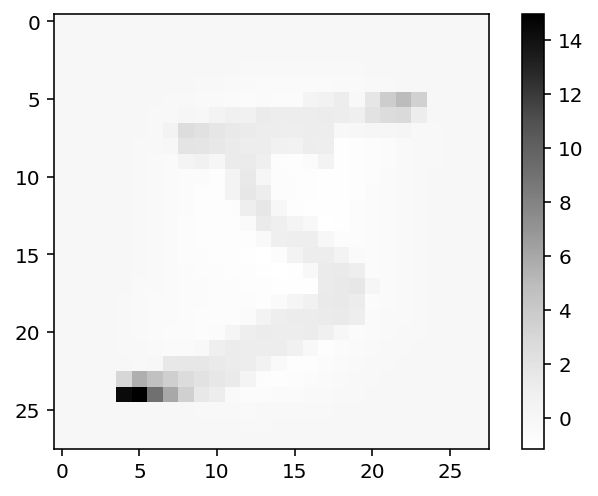

In [75]:
plt.imshow(x_t_[0], cmap=plt.get_cmap('Greys'))
plt.colorbar();

In [76]:
model.fit(x_t_, y_t, epochs=n_epochs)
print('Validate')
val_loss, val_acc = model.evaluate(x_v_, y_v)

Epoch 1/3
1875/1875 [==============================] - 15s 8ms/step - loss: 0.8098 - accuracy: 0.7642
Epoch 2/3
1875/1875 [==============================] - 15s 8ms/step - loss: 0.5249 - accuracy: 0.8598
Epoch 3/3
1875/1875 [==============================] - 15s 8ms/step - loss: 0.4056 - accuracy: 0.8918
Validate
313/313 [==============================] - 1s 4ms/step - loss: 0.3713 - accuracy: 0.9019


Check with ELU.

In [77]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Flatten())  # Input layer
model.add(tf.keras.layers.Dense(128, activation=tf.nn.elu)) # first hidden

for l in range(98):
  model.add(tf.keras.layers.Dense(64, activation=tf.nn.elu)) # middle layers

model.add(tf.keras.layers.Dense(10, activation=tf.nn.softmax)) # output layer
model.compile(optimizer=tf.keras.optimizers.SGD(lr=1e-3), # not 'adam'
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])
model.fit(x_t_, y_t, epochs=n_epochs)
print('Validate')
val_loss, val_acc = model.evaluate(x_v_, y_v)

Epoch 1/3
1875/1875 [==============================] - 15s 8ms/step - loss: 2.0652 - accuracy: 0.1793
Epoch 2/3
1875/1875 [==============================] - 15s 8ms/step - loss: 1.7981 - accuracy: 0.2012
Epoch 3/3
1875/1875 [==============================] - 16s 8ms/step - loss: 1.6692 - accuracy: 0.2969
Validate
313/313 [==============================] - 1s 4ms/step - loss: 1.4356 - accuracy: 0.4306


The take away here is that we should normalize with SELU to take full advantage of the structure of SELU, but it doesn't provide any advantage with ELU.

## Batch normalization

Batch normalization is a technique to normalize the outputs of the network before the activation.

In [78]:
layer_size = [128, 32, 16]
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Flatten())  # Input layer

for s in layer_size:
  model.add(tf.keras.layers.BatchNormalization())
  model.add(tf.keras.layers.Dense(s, activation=tf.nn.elu))

model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dense(10, activation=tf.nn.softmax)) # output layer
model.compile(optimizer='adam', 
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])

In [79]:
model.fit(x_t, y_t, epochs=n_epochs)
print('Validate')
val_loss, val_acc = model.evaluate(x_v, y_v)

Epoch 1/3
1875/1875 [==============================] - 6s 3ms/step - loss: 0.2916 - accuracy: 0.9205
Epoch 2/3
1875/1875 [==============================] - 6s 3ms/step - loss: 0.1353 - accuracy: 0.9587
Epoch 3/3
1875/1875 [==============================] - 5s 3ms/step - loss: 0.1037 - accuracy: 0.9674
Validate
313/313 [==============================] - 1s 2ms/step - loss: 0.0998 - accuracy: 0.9710


Compared to the network without `BatchNormalization` we got some gain.

## Dropout

Dropout is the brutal but effective idea to drop a fraction of the neurons at random during training to make the network less reliant on a few neurons. It's a method to reduce overfitting. Especially with large, deep networks, it might a quick and good idea to use it. 

`Dropout` goes after `Dense`.

In [80]:
layer_size = [128, 32, 16]
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Flatten())  # Input layer

for s in layer_size:
  # model.add(tf.keras.layers.BatchNormalization())
  model.add(tf.keras.layers.Dense(s, activation=tf.nn.elu))
  model.add(tf.keras.layers.Dropout(rate=0.2))

model.add(tf.keras.layers.Dense(10, activation=tf.nn.softmax)) # output layer
model.compile(optimizer='adam', 
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])

In [81]:
model.fit(x_t, y_t, epochs=n_epochs)
print('Validate')
val_loss, val_acc = model.evaluate(x_v, y_v)

Epoch 1/3
1875/1875 [==============================] - 4s 2ms/step - loss: 0.4925 - accuracy: 0.8524
Epoch 2/3
1875/1875 [==============================] - 4s 2ms/step - loss: 0.2785 - accuracy: 0.9188
Epoch 3/3
1875/1875 [==============================] - 4s 2ms/step - loss: 0.2236 - accuracy: 0.9366
Validate
313/313 [==============================] - 1s 2ms/step - loss: 0.1290 - accuracy: 0.9606


It seems that we don't gain anything. Two remarks: 1) there might be an optimum dropout rate such that the performance actually improves; 2) it is quite surprising (even though well known) that dropout does not reduce performance, at least if well designed.

## Dropout + BatchNormalization

In [82]:
layer_size = [128, 32, 16]
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Flatten())  # Input layer

for s in layer_size:
  model.add(tf.keras.layers.BatchNormalization())
  model.add(tf.keras.layers.Dense(s, activation=tf.nn.elu))
  model.add(tf.keras.layers.Dropout(rate=0.025))

model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dense(10, activation=tf.nn.softmax)) # output layer
model.compile(optimizer='adam', 
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])

In [83]:
model.fit(x_t, y_t, epochs=n_epochs)
print('Validate')
val_loss, val_acc = model.evaluate(x_v, y_v)

Epoch 1/3
1875/1875 [==============================] - 6s 3ms/step - loss: 0.3315 - accuracy: 0.9073
Epoch 2/3
1875/1875 [==============================] - 6s 3ms/step - loss: 0.1555 - accuracy: 0.9534
Epoch 3/3
1875/1875 [==============================] - 6s 3ms/step - loss: 0.1230 - accuracy: 0.9615
Validate
313/313 [==============================] - 1s 2ms/step - loss: 0.0969 - accuracy: 0.9721


## Convolutional network

We've seen that data augmentation helps. The only data augmentation that we tried is to apply rotations, which makes the approximation rotation-invariant. 

All sorts of operators can be applied to make the network less sensitive to those transformations. This is, of course, a data-dependent task: If we were to locate an object, we wouldn't use a convolutional network because it is designed to be insensitive to translation. However, here we are trying to recognize objects, and therefore the position of the object (digit) is not important at all.

When designing a convolutional layer, we have to specify:

*   The size of the kernel (e.g. a 3x3 kernel);
*   The stride (e.g. a 2x2 stride), which is the “gap” between two applications of the kernel on the image;
*   The number of filters (more on this below).

Unless important for the specific problem at hand, it makes sense to keep the aspect ratio of the original image. Instead of providing the layer with pairs for kernel size and stride, we can just input an integer. For example, we can define the size of the kernel to be 3, which actually means a 3x3 kernel.

Typically following convolutional layers there are pooling layers, which are there to summarize the data in the previous layer based on some operation. If the operation is the maximum, then we have max-pooling. Other kinds of pooling are possible (e.g. average).

After pooling, we flatten, and proceed as before.

As for the number of filters mentioned above: We can actually add many filters. All these filters have their own weights and output a new image. We stack all of these 2D images on top of each other at the output of the convolutional layer. The number of the filters is defined by `filters`.

General guidelines for good architectures
* strides should be small (1 or 2, where 1 is the minimum gap anyway)
* kernels should be reasonably small (up to 10)
* filters should be large and increasing (to compensate for the smaller dimensions of the images)
* pool size should be small (up to 4)




In [84]:
# Prepare the data
x_t_cnn = np.expand_dims(x_t, -1)
x_v_cnn = np.expand_dims(x_v, -1)

In [85]:
# Model definition
model = tf.keras.models.Sequential()

for filters in [16, 32]:
  model.add(tf.keras.layers.BatchNormalization(input_shape=x_t_cnn.shape[1:]))
  model.add(tf.keras.layers.Conv2D(filters=filters, kernel_size=4, padding='same', activation='elu'))
  model.add(tf.keras.layers.MaxPooling2D(pool_size=4, strides=2))

# model.add(tf.keras.layers.GlobalAvgPool2D()) # idea from ResNet

model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(128, activation=tf.nn.elu))
model.add(tf.keras.layers.Dense(32, activation=tf.nn.elu))
model.add(tf.keras.layers.Dense(16, activation=tf.nn.elu))
model.add(tf.keras.layers.Dense(10,activation=tf.nn.softmax))

model.compile(optimizer='adam', 
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])

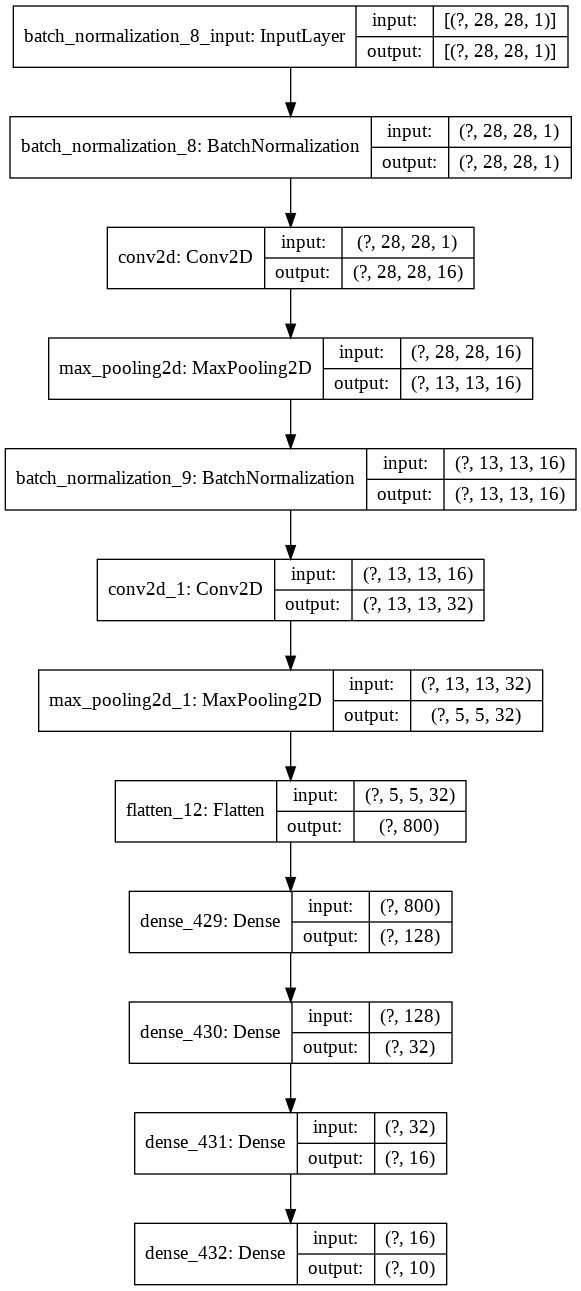

In [86]:
tf.keras.utils.plot_model(model, "model.png", show_shapes=True)

In [87]:
model.build()
print(model.summary())

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_8 (Batch (None, 28, 28, 1)         4         
_________________________________________________________________
conv2d (Conv2D)              (None, 28, 28, 16)        272       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 16)        0         
_________________________________________________________________
batch_normalization_9 (Batch (None, 13, 13, 16)        64        
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 13, 13, 32)        8224      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 32)          0         
_________________________________________________________________
flatten_12 (Flatten)         (None, 800)             

In [88]:
# Launch the model
model.fit(x_t_cnn, y_t, epochs=n_epochs)
print('Validate')
val_loss, val_acc = model.evaluate(x_v_cnn, y_v)

Epoch 1/3
1875/1875 [==============================] - 5s 3ms/step - loss: 0.1558 - accuracy: 0.9525
Epoch 2/3
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0504 - accuracy: 0.9848
Epoch 3/3
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0373 - accuracy: 0.9888
Validate
313/313 [==============================] - 1s 2ms/step - loss: 0.0457 - accuracy: 0.9876


## More augmentation

We can think about the transformations that our dataset could be subject to that shouldn't change the end result. A tentative list is as follows:

*   Black and white with different threshols
*   Stretching and applying different aspect ratios

Then, we could just repeat the steps above with a larger, more augmented dataset.


## Where are the errors: A look into the “black box”

By analyzing where the errors occur, we can improve the behavior of the network on those instances. It is quite unlikely to misinterpret a 0 as a 1, but the same cannot be said for a 5 for a 6. After all, the correlation between 5 and 6 is quite high in reality, while the correlation between 0 and 1 is low. 

We could spend some effort in improving the recognition of similar objects with dedicated estimators, and combine different estimators to get better performance. This approach belongs to the so-called ensemble methods, which we'll investigate in another notebook.